# MC Control 

We will be using MC Control on sample 4x4 grid world 

![GridWorld](./images/gridworld.png "Grid World")


### Monte Carlo Prediction for Estimation ("first-visit")

Monte Carlo Prediction is carried out by sampling the trajectories over many episodes and using the rewards seen in samples as estimate for state values. The backup digram is given below. Pseudo code for the algorithm is given in Fig 4-1

![MC backup](./images/mc_backup.png "MC Backup")

### Monte Carlo greedy Policy Improvement

We will use $ \epsilon$-greedy policy improvement approach as discussed in the text. 


In [1]:
# Initial imports and enviroment setup
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

# create grid world invironment
from gridworld import GridworldEnv
env = GridworldEnv()

In [2]:
# MC Prediction

def mc_policy_eval(policy, env, discount_factor=1.0, episode_count=100):
    """
    Evaluate a policy given an environment.

    Args:
        policy:[S, A] shaped matrix representing the policy. Random in our case
        env: OpenAI env. In model free setup you have no access to env.P,
             transition dynamics of the environment.
             use step(a) to take an action and receive a tuple
             of (s', r, done, info)
             env.nS is number of states in the environment.
             env.nA is number of actions in the environment.
        episode_count: Number of episodes:
        discount_factor: Gamma discount factor.

    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with (all 0) state value array and a visit count of zero
    V = np.zeros(env.nS)
    N = np.zeros(env.nS)
    i = 0

    # run multiple episodes
    while i < episode_count:

        # collect samples for one episode
        episode_states = []
        episode_returns = []
        state = env.reset()
        episode_states.append(state)
        while True:
            action = np.random.choice(env.nA, p=policy[state])
            (state, reward, done, _) = env.step(action)
            episode_returns.append(reward)
            if not done:
                episode_states.append(state)
            else:
                break

        # update state values
        G = 0
        count = len(episode_states)
        for t in range(count-1, -1, -1):
            s, r = episode_states[t], episode_returns[t]
            G = discount_factor * G + r
            if s not in episode_states[:t]:
                N[s] += 1
                V[s] = V[s] + 1/N[s] * (G-V[s])

        i = i+1

    return np.array(V)

In [3]:
# Greedy in the Limit with Infinite Exploration (GLIE)

def GLIE(env, discount_factor=1.0, episode_count=100):
    """
    Find optimal policy given an environment.

    Args:
        env: OpenAI env. In model free setup you have no access to env.P,
             transition dynamics of the environment.
             use step(a) to take an action and receive a tuple
             of (s', r, done, info)
             env.nS is number of states in the environment.
             env.nA is number of actions in the environment.
        episode_count: Number of episodes:
        discount_factor: Gamma discount factor.

    Returns:
        Vector of length env.nS representing the value function.
        policy:[S, A] shaped matrix representing the policy. Random in our case

    """
    # Start with (all 0) state value array and state-action matrix.
    # also initialize visit count to zero for the state-action visit count.
    V = np.zeros(env.nS)
    N = np.zeros((env.nS, env.nA))
    Q = np.zeros((env.nS, env.nA))
    # random policy
    policy = [np.random.randint(env.nA) for _ in range(env.nS)]
    k = 1
    eps = 1

    def argmax_a(arr):
        """
        Return idx of max element in an array.
        Break ties uniformly.
        """
        max_idx = []
        max_val = float('-inf')
        for idx, elem in enumerate(arr):
            if elem == max_val:
                max_idx.append(idx)
            elif elem > max_val:
                max_idx = [idx]
                max_val = elem
        return np.random.choice(max_idx)

    def get_action(state):
        if np.random.random() < eps:
            return np.random.choice(env.nA)
        else:
            return argmax_a(Q[state])

    # run multiple episodes
    while k <= episode_count:

        # collect samples for one episode
        episode_states = []
        episode_actions = []
        episode_returns = []
        state = env.reset()
        episode_states.append(state)
        while True:
            action = get_action(state)
            episode_actions.append(action)
            (state, reward, done, _) = env.step(action)
            episode_returns.append(reward)
            if not done:
                episode_states.append(state)
            else:
                break

        # update state-action values
        G = 0
        count = len(episode_states)
        for t in range(count-1, -1, -1):
            s, a, r = episode_states[t], episode_actions[t], episode_returns[t]
            G = discount_factor * G + r
            N[s, a] += 1
            Q[s, a] = Q[s, a] + 1/N[s, a] * (G-Q[s, a])

        # Update policy and optimal value
        k = k+1
        eps = 1/k
        # uncomment "if" to have higher exploration initially and
        # then let epislon decay after 5000 episodes
        #if k <=100:
        #    eps = 0.02

        for s in range(env.nS):
            best_action = argmax_a(Q[s])
            policy[s] = best_action
            V[s] = Q[s, best_action]

    return np.array(V), np.array(policy)

In [4]:
# Custom print to show state values inside the grid
def grid_print(V, k=None, shade_cell=True):
    ax = sns.heatmap(V.reshape(env.shape),
                     annot=True, square=True,
                     cbar=False, cmap='Blues',
                     xticklabels=False, yticklabels=False)

    if k:
        ax.set(title="K = {0}".format(k))
    plt.show()

policy

 [['*' 'LEFT' 'LEFT' 'LEFT']
 ['UP' 'LEFT' 'DOWN' 'UP']
 ['UP' 'DOWN' 'RIGHT' 'DOWN']
 ['RIGHT' 'RIGHT' 'RIGHT' '*']]


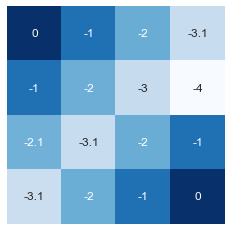

In [5]:
# run mc policy control GLIE
V_pi, policy = GLIE(env, discount_factor=1.0, episode_count=10000)

action_labels = {0:"UP", 1:"RIGHT", 2: "DOWN", 3:"LEFT"}
# print policy
optimal_actions = [action_labels[policy[s]] for s in range(env.nS)]
optimal_actions[0] = "*" 
optimal_actions[-1] = "*" 

print("policy\n\n",np.array(optimal_actions).reshape(env.shape))

# print state values
grid_print(V_pi.reshape(env.shape))

### Conclusion

We see that policy and state values converge fairly well for 1000 episode simulation. There are some states which have wrong value most likely due to fast decay of epsilon. We need more exploration in initial episode which is controlled by the epsilon value. We are taking it as 1/k which reduces exploration very fast. It may be better to have epsilon=0.05 or something like that for first 100-1000 episodes and then let epsilon reduce as 1/k. 